In [17]:
import numpy as np
import pandas as pd
import time

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier

from xgboost import XGBClassifier


from math import sqrt
import seaborn as sns
import matplotlib.pyplot as plt

import datasource_config

In [18]:
# Read the processed dataset.
# using config file for source data path
path = datasource_config.CLASSIFICATION_SOURCE_DATA_PATH
phm_df = pd.read_parquet(path, engine='fastparquet')

In [19]:
# The below logic will split the 3 sensors array columns into separate 571 columns each.
phm_split_df = None
for i, sensor in enumerate(['pdmp', 'pin', 'po']):
    temp_split_df = phm_df[sensor].apply(pd.Series)
    temp_split_df.columns = [sensor + '_' + str(x) for x in range(1, 572)]

    if (i == 0):
        phm_split_df = pd.concat([phm_df[['index', 'fault_class', 'individual']], temp_split_df], axis=1)
        print("Length of phm_split_df.columns: ", len(phm_split_df.columns))
    else:
        phm_split_df = pd.concat([phm_split_df, temp_split_df], axis=1)
        print("Length of phm_split_df.columns: ", len(phm_split_df.columns))
phm_split_df.columns

Length of phm_split_df.columns:  574
Length of phm_split_df.columns:  1145
Length of phm_split_df.columns:  1716


Index(['index', 'fault_class', 'individual', 'pdmp_1', 'pdmp_2', 'pdmp_3',
       'pdmp_4', 'pdmp_5', 'pdmp_6', 'pdmp_7',
       ...
       'po_562', 'po_563', 'po_564', 'po_565', 'po_566', 'po_567', 'po_568',
       'po_569', 'po_570', 'po_571'],
      dtype='object', length=1716)

In [20]:
phm_df = phm_split_df
phm_df

,index,fault_class,individual,pdmp_1,pdmp_2,pdmp_3,pdmp_4,pdmp_5,pdmp_6,pdmp_7,...,po_562,po_563,po_564,po_565,po_566,po_567,po_568,po_569,po_570,po_571
0,22776,3,5,-0.194942,-0.187465,-0.180348,-0.173447,-0.168120,-0.164938,-0.162964,...,1.050622,1.034456,1.006829,0.981712,0.982890,0.995431,0.997414,0.981866,0.969041,0.971418
1,22777,8,5,-0.246213,-0.273524,-0.308485,-0.348401,-0.388465,-0.423755,-0.450124,...,0.912746,0.908318,0.922986,0.935062,0.936170,0.941296,0.953447,0.959849,0.951849,0.934557
2,22778,4,5,0.276173,0.256051,0.233923,0.207697,0.179566,0.149646,0.118753,...,0.921702,0.926112,0.928393,0.930782,0.940371,0.956150,0.957770,0.939279,0.927833,0.935658
3,22779,2,5,0.065800,0.057669,0.051469,0.047736,0.045938,0.047479,0.052721,...,0.422891,0.428285,0.432260,0.430246,0.419753,0.400856,0.375741,0.351293,0.335347,0.331829
4,22780,2,5,0.277680,0.272525,0.265093,0.256061,0.246930,0.238751,0.234863,...,0.388398,0.383101,0.390316,0.395677,0.395287,0.384548,0.363969,0.339599,0.317733,0.305070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34140,34141,1,6,-0.051017,-0.055426,-0.061033,-0.070764,-0.087975,-0.112000,-0.141544,...,0.945983,0.945088,0.944416,0.952775,0.959355,0.946094,0.927905,0.931097,0.954974,0.976086
34141,34142,1,6,0.027704,0.008840,-0.005844,-0.015680,-0.020587,-0.017767,-0.007995,...,0.948468,0.960261,0.954239,0.927050,0.902973,0.902458,0.920599,0.937222,0.946607,0.952880
34142,34143,1,6,-0.037775,-0.053561,-0.073233,-0.097449,-0.124788,-0.155356,-0.188065,...,0.951262,0.939103,0.912608,0.901967,0.918477,0.943463,0.955312,0.953058,0.956575,0.964654
34143,34144,1,6,0.095459,0.086675,0.078642,0.068852,0.057889,0.044362,0.029811,...,0.915304,0.936355,0.945232,0.937995,0.914667,0.887997,0.889253,0.923887,0.949244,0.947865


In [21]:
# Split the data into features (X) and target (y)
X = phm_df.drop(['index', 'fault_class'], axis=1)
y = phm_df['fault_class']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train

,individual,pdmp_1,pdmp_2,pdmp_3,pdmp_4,pdmp_5,pdmp_6,pdmp_7,pdmp_8,pdmp_9,...,po_562,po_563,po_564,po_565,po_566,po_567,po_568,po_569,po_570,po_571
28987,2,0.001250,0.007385,0.011914,0.018709,0.026933,0.040997,0.060689,0.083472,0.106869,...,1.166960,1.159119,1.143334,1.133456,1.126619,1.138820,1.158383,1.179532,1.200106,1.213957
30565,2,0.222449,0.241569,0.259469,0.274638,0.287031,0.296824,0.306680,0.317045,0.324698,...,1.103043,1.091834,1.094093,1.095972,1.088168,1.075968,1.070559,1.064229,1.048538,1.032563
31388,6,0.055796,0.030657,0.010697,-0.001894,-0.010901,-0.021843,-0.037291,-0.058300,-0.081906,...,0.974787,0.956876,0.925533,0.906165,0.914830,0.947811,0.972396,0.972137,0.962747,0.962114
27474,2,0.041017,0.049689,0.056392,0.065032,0.073639,0.086113,0.101697,0.118559,0.135662,...,1.075901,1.089886,1.115230,1.122477,1.104326,1.085069,1.071063,1.051729,1.020248,0.987962
11814,4,-0.233978,-0.217745,-0.201665,-0.184400,-0.169254,-0.158375,-0.155596,-0.162259,-0.179894,...,0.981608,0.979666,0.983526,0.981229,0.984852,0.993940,0.993938,0.976931,0.948514,0.928661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29015,2,0.043033,0.085501,0.117591,0.138842,0.147602,0.146859,0.141120,0.133412,0.127838,...,1.141285,1.138835,1.124924,1.092554,1.065538,1.059199,1.073217,1.090517,1.104766,1.109775
6227,5,-0.512381,-0.543630,-0.568406,-0.583411,-0.586615,-0.580514,-0.566502,-0.546239,-0.522918,...,0.938472,0.941422,0.942400,0.945031,0.942255,0.926375,0.908059,0.906248,0.918631,0.930984
14041,4,-0.235529,-0.268303,-0.303106,-0.335514,-0.364816,-0.386746,-0.399294,-0.401828,-0.394678,...,1.091792,1.069722,1.034628,1.014184,1.014587,1.020574,1.021780,1.018967,1.017840,1.012540
21242,1,0.245024,0.224552,0.205027,0.187542,0.170960,0.153452,0.138263,0.122761,0.107527,...,1.127205,1.141580,1.150136,1.167599,1.193811,1.206644,1.187852,1.141696,1.106233,1.104386


In [23]:
# Train the model for different learning rates and check results:
lr_list = [0.25, 0.5, 0.75, 1]
train_accuracy_list = []
test_accuracy_list = []
precision_list = []
f1_list = []
recall_list = []

for learning_rate in lr_list:

    # get the start time
    st = time.time()

    gb_clf = GradientBoostingClassifier(n_estimators=5, learning_rate=learning_rate, max_features='log2', max_depth=3, random_state=0)
    gb_clf.fit(X_train, y_train)
    # get the end time
    et = time.time()

    # get the execution time
    elapsed_time = et - st
    print('Modelling training time:', elapsed_time, 'seconds')

    print("Learning rate: ", learning_rate)
    train_accuracy_score = gb_clf.score(X_train, y_train)
    train_accuracy_list.append(train_accuracy_score)
    test_accuracy_score = gb_clf.score(X_test, y_test)
    test_accuracy_list.append(test_accuracy_score)
    print("Accuracy score (training): {0:.3f}".format(train_accuracy_score))
    print("Accuracy score (testing): {0:.3f}".format(test_accuracy_score))

    accuracy_scores = cross_val_score(gb_clf, X, y, cv=5, scoring='accuracy')
    precision_scores = cross_val_score(gb_clf, X, y, cv=5, scoring='precision_macro')
    recall_scores = cross_val_score(gb_clf, X, y, cv=5, scoring='recall_macro')
    f1_scores = cross_val_score(gb_clf, X, y, cv=5, scoring='f1_macro')

    print("CROSS VALIDATION SCORES: ")
    print("Accuracy Score: ", np.mean(accuracy_scores))
    print("Precision Score: ", np.mean(precision_scores))
    precision_list.append(np.mean(precision_scores))
    print("Recall Score: ", np.mean(recall_scores))
    recall_list.append(np.mean(recall_scores))
    print("F1 Score: ", np.mean(f1_scores))
    f1_list.append(np.mean(f1_scores))
        

Modelling training time: 4.991406202316284 seconds
Learning rate:  0.25
Accuracy score (training): 0.835
Accuracy score (testing): 0.817
CROSS VALIDATION SCORES: 
Accuracy Score:  0.6976131205154488
Precision Score:  0.7133504511002932
Recall Score:  0.6901330871242893
F1 Score:  0.6802174457311458
Modelling training time: 4.686845064163208 seconds
Learning rate:  0.5
Accuracy score (training): 0.863
Accuracy score (testing): 0.839
CROSS VALIDATION SCORES: 
Accuracy Score:  0.7365353638892957
Precision Score:  0.7428959577532441
Recall Score:  0.729382780708845
F1 Score:  0.7225908577564534
Modelling training time: 5.118107795715332 seconds
Learning rate:  0.75
Accuracy score (training): 0.875
Accuracy score (testing): 0.853
CROSS VALIDATION SCORES: 
Accuracy Score:  0.747225069556304
Precision Score:  0.7537563068427562
Recall Score:  0.7409605853268838
F1 Score:  0.7356504116603908
Modelling training time: 4.78087306022644 seconds
Learning rate:  1
Accuracy score (training): 0.870
Ac

test_accuracy_list:  [0.817249963391419, 0.8389222433738468, 0.8534192414702007, 0.849319080392444]
learning_rate:  [0.25, 0.5, 0.75, 1]


Text(0, 0.5, 'Testing Accuracy Scores')

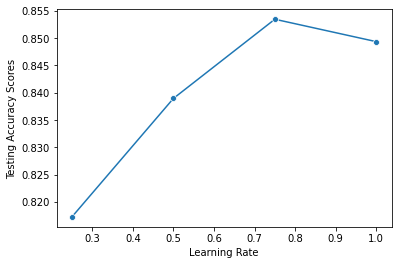

In [24]:
print("test_accuracy_list: ", test_accuracy_list)
print("learning_rate: ", lr_list)
sns.lineplot(x = lr_list, y = test_accuracy_list, marker = 'o')
plt.xlabel("Learning Rate")
plt.ylabel("Testing Accuracy Scores")


train_accuracy_list:  [0.8347854737150388, 0.8627544296383072, 0.8754209986820911, 0.8703324059159467]
learning_rate:  [0.25, 0.5, 0.75, 1]


Text(0, 0.5, 'Training Accuracy Scores')

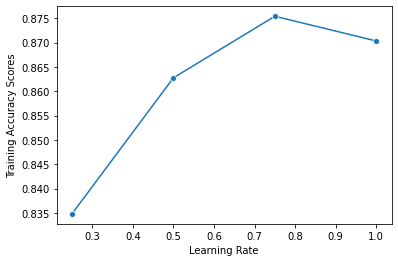

In [25]:
print("train_accuracy_list: ", train_accuracy_list)
print("learning_rate: ", lr_list)
sns.lineplot(x = lr_list, y = train_accuracy_list, marker = 'o')
plt.xlabel("Learning Rate")
plt.ylabel("Training Accuracy Scores")

Text(0, 0.5, 'Recall Scores')

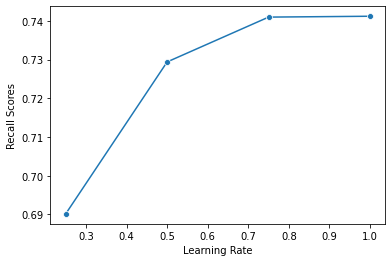

In [26]:
sns.lineplot(x = lr_list, y = recall_list, marker = 'o')
plt.xlabel("Learning Rate")
plt.ylabel("Recall Scores")


Text(0, 0.5, 'F1 Scores')

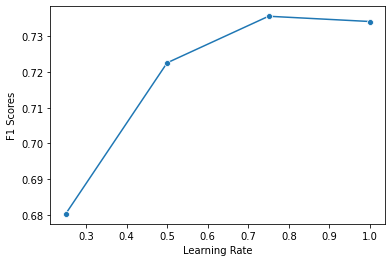

In [27]:
sns.lineplot(x = lr_list, y = f1_list, marker = 'o')
plt.xlabel("Learning Rate")
plt.ylabel("F1 Scores")


In [16]:
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]
train_accuracy_list = []
test_accuracy_list = []

xgb_clf = XGBClassifier(learning_rate = 1.0, n_estimators=300, max_depth=5)
# get the start time
st = time.time()

xgb_clf.fit(X_train, y_train - 1)
# get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print('Modelling training time:', elapsed_time, 'seconds')

test_score = xgb_clf.score(X_test, y_test - 1)
print("Testing Score: ", test_score)
train_score = xgb_clf.score(X_train, y_train - 1)
print("Training Score", train_score)


Modelling training time: 430.4919250011444 seconds
Testing Score:  0.9973641821642993
Training Score 1.0


In [29]:
cm = confusion_matrix(y_test-1, y_pred)
cm

array([[62, 61, 46, 60, 53, 53, 60, 59, 40, 46, 73],
       [60, 64, 65, 62, 64, 58, 55, 53, 78, 56, 65],
       [64, 51, 50, 48, 51, 65, 60, 50, 58, 61, 52],
       [60, 66, 59, 57, 53, 68, 62, 56, 57, 34, 67],
       [49, 66, 53, 55, 59, 65, 60, 47, 49, 50, 59],
       [49, 66, 53, 66, 55, 54, 59, 49, 54, 54, 58],
       [51, 58, 59, 55, 59, 52, 61, 53, 61, 55, 69],
       [64, 80, 55, 53, 65, 65, 56, 67, 46, 43, 60],
       [57, 60, 54, 74, 56, 59, 58, 49, 58, 47, 55],
       [54, 59, 42, 31, 46, 43, 47, 49, 52, 38, 46],
       [59, 57, 51, 57, 50, 48, 58, 74, 68, 54, 61]])

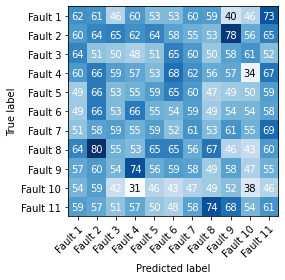

In [30]:
# plot the confusion matrix as an image
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=['Fault ' + str(x) for x in range(1, 12)],
       yticklabels=['Fault ' + str(x) for x in range(1, 12)],
       xlabel='Predicted label',
       ylabel='True label')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# add the values to the plot
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'), ha="center", va="center", color="white" if cm[i, j] > cm.max() / 2. else "black")

fig.tight_layout()
plt.show()
